In [1]:
# Importação de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.color import grey2rgb
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.resnet import ResNet152

In [2]:
# Visualização e pré-processamento do conjunto de dados
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = './archive-2/Training',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 2297 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = './archive-2/Testing',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 78 images belonging to 4 classes.


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.60s/it]


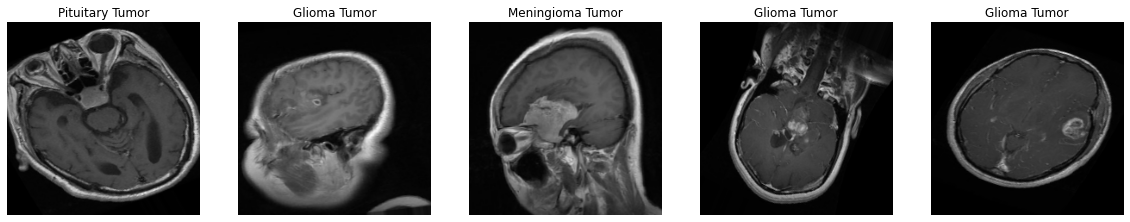

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Glioma Tumor')
    elif a[1] == 1:
        ax[i].set_title('Meningioma Tumor')
    elif a[2] == 1:
        ax[i].set_title('No Tumor')
    elif a[3] == 1:
        ax[i].set_title('Pituitary Tumor')

In [6]:
# Inicialização do modelo

base_model = DenseNet121(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

2022-09-15 18:14:03.366076: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


29097984/29084464 [==============================] - 53s 2us/step


In [7]:
# Congelamento de camadas

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Construção do modelo

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 7, 7, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 batch_normalization (BatchN  (None, 50176)            200704    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              102762496 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [10]:
# Compilação do modelo

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [11]:
# Definição de gráficos

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [12]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 0.8803 - auc: 0.8995 
Epoch 1: val_auc improved from -inf to 0.72496, saving model to ./best_weights.hdf5
18/18 [==============================] - 349s 19s/step - loss: 0.8803 - auc: 0.8995 - val_loss: 13.2687 - val_auc: 0.7250
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 0.5725 - auc: 0.9500 
Epoch 2: val_auc did not improve from 0.72496
18/18 [==============================] - 324s 18s/step - loss: 0.5725 - auc: 0.9500 - val_loss: 7.8554 - val_auc: 0.7177
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.4184 - auc: 0.9703 
Epoch 3: val_auc improved from 0.72496 to 0.73302, saving model to ./best_weights.hdf5
18/18 [==============================] - 315s 17s/step - loss: 0.4184 - auc: 0.9703 - val_loss: 5.9296 - val_auc: 0.7330
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 0.3864 - auc: 0.9738 
Epoch 4: val_auc improved from 0.73302 to 0.75627, saving m

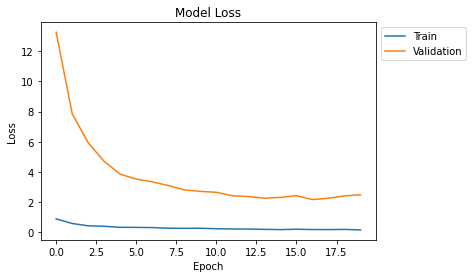

In [13]:
#Model Evaluation
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

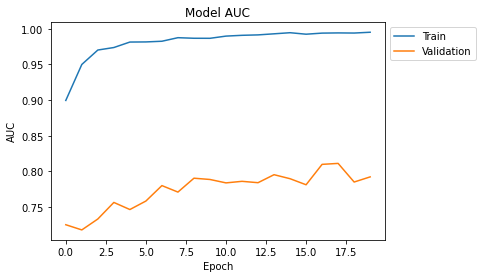

In [14]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [15]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = './archive-2/Testing',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 394 images belonging to 4 classes.


In [16]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

4/4 [==============================] - 52s 12s/step - loss: 1.8663 - auc: 0.8638


[1.8663023710250854, 0.8637526035308838]